In [1]:
import pickle
import os, sys
import numpy as np
import matplotlib.pyplot as plt
os.chdir('../src')  # to avoid importing utils Anaconda package
from plot_utils import plot_maze_stats
from parameters import RewNames, INVALID_STATE, RWD_NODE
from TDLambda_Home2Rwd_model import TDLambda_Home2Rwd
os.chdir('../TDLambda_Home2Rwd_stan')
save_dir = 'figures/'

model = TDLambda_Home2Rwd()

In [2]:
def reformat_realtraj(real_traj):
    '''
    Remove INVALID_STATE from real trajectories and reshape 3D array to a 1D array for plotting functions
    :param real_traj: 3D array: [N, BOUTS, TRAJ_LENGTH] of extracted trajectories
    :return real trajectories formatted as a list of lists without INVALID_STATE
    '''
    real_traj_lists = [[] for _ in range(len(real_traj))]
    for mouseID in np.arange(len(real_traj)):
        for traj in real_traj[mouseID]:
            valid_traj = traj[traj!=INVALID_STATE]
            if len(valid_traj):
                real_traj_lists[mouseID].extend(valid_traj)
    return real_traj_lists

def revise_subfits(real_traj, exclude=None):
    '''
    Exclude specific mice from analysis
    :param real_traj: 3D array: [N, BOUTS, TRAJ_LENGTH] of extracted trajectories
    :param exclude: list of mouseIDs to exclude from simulations if their parameter fits didn't converge in STAN
    :return parameter fits, bout counts, rewards and miceIDs, ONLY of mice to be included in the analysis
    '''
    if exclude:
        for mouseID in exclude:
            org_sub_fits.pop(mouseID)
        sub_fits = dict(zip(np.arange(len(real_traj)-len(exclude)), org_sub_fits.values()))
    else:
        sub_fits = org_sub_fits
    real_mouseID = set(np.arange(len(real_traj))) - set(exclude)
    
    # Retrieve number of bouts each mouse learned over
    N_BOUTS_TO_GENERATE = [len(np.where(traj_list[:,0]!=INVALID_STATE)[0]) for traj_list in real_traj]
    N_BOUTS_TO_GENERATE = [N_BOUTS_TO_GENERATE[id] for id in real_mouseID]
    
    # Sum total rewards each mouse earned
    NRWDS = np.zeros(len(real_traj), dtype=int)
    RWD_RATE = [[] for _ in range(len(real_traj))]
    for mouseID in np.arange(len(real_traj)):
        for traj_list in real_traj[mouseID]:
            RWD_RATE[mouseID].extend([len(np.where(traj_list==RWD_NODE)[0])])
            NRWDS[mouseID] += len(np.where(traj_list==RWD_NODE)[0])
    NRWDS = [NRWDS[id] for id in real_mouseID]    
    
    return sub_fits, real_mouseID, N_BOUTS_TO_GENERATE, NRWDS, RWD_RATE

def rand_LL(real_traj_lists):
    '''
    Calculate the log likelihood of a random policy fitting to real data of each mouse
    :param real_traj_lists[len(real_traj)] list containing a list of combined real trajectories for each mouse
    :return 1-by-len(real_traj) array of random log likelihoods
    '''
    indv_rand_LL = np.zeros(len(real_traj))
    for mouseID in np.arange(len(real_traj)):
        indv_rand_LL[mouseID] += len(real_traj_lists[mouseID]) * np.log(0.33)
    return indv_rand_LL

# Loading real data
real_traj = pickle.load(open('traj_data/real_traj/rewMICE_post_firstR_every_Rvisit.pkl','rb'))
real_traj_lists = reformat_realtraj(real_traj)
indv_rand_LL = rand_LL(real_traj_lists)

# Retrieving fitted subject parameters
org_sub_fits = pickle.load(open('results/TDlamda_Rvisit_real_init0.1/sub_fits.pkl','rb'))
sub_fits, real_mouseID, N_BOUTS, NRWDS, RWD_RATE = revise_subfits(real_traj, [0,2,8])

In [3]:
RUNS = 1
N_BOUTS_TO_GENERATE = [b for b in N_BOUTS]
avg_state_value_hist, total_pred_traj, total_rwds, pred_rwd_rate = model.simulate_avg(sub_fits, RUNS=RUNS, N_BOUTS_TO_GENERATE=N_BOUTS_TO_GENERATE)

Running simulation  0


In [11]:
# Combining all predicted trajectories for each mouse across bouts and runs
total_pred_traj_list = [[] for _ in range(len(sub_fits))]
[total_pred_traj_list[mouseID].extend(traj) for mouseID in np.arange(len(sub_fits)) for run in total_pred_traj[mouseID] for traj in run];

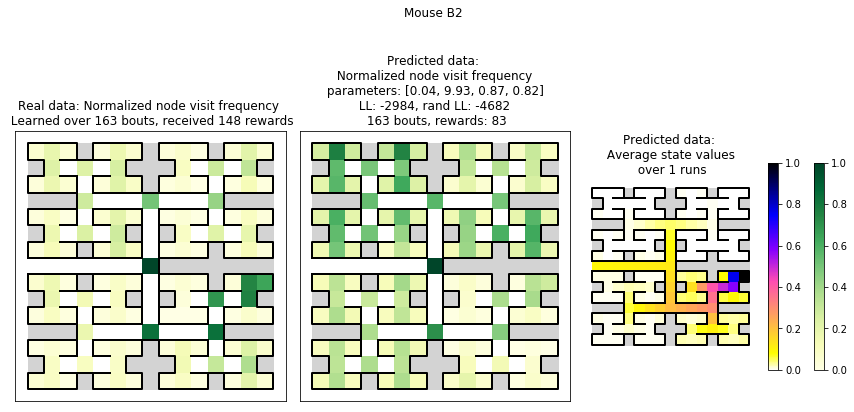

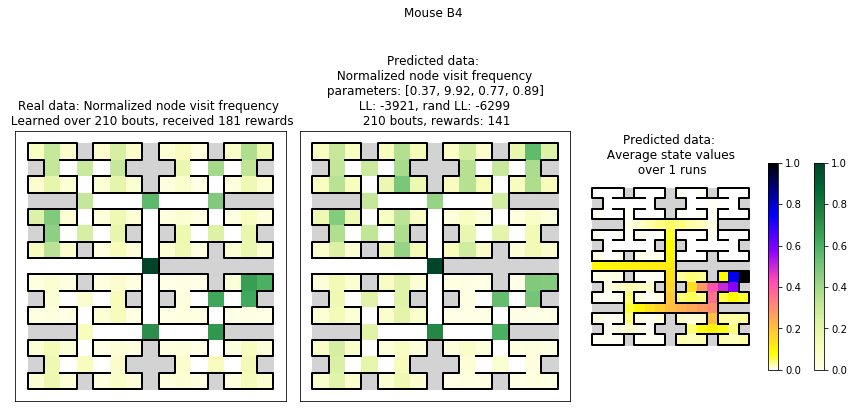

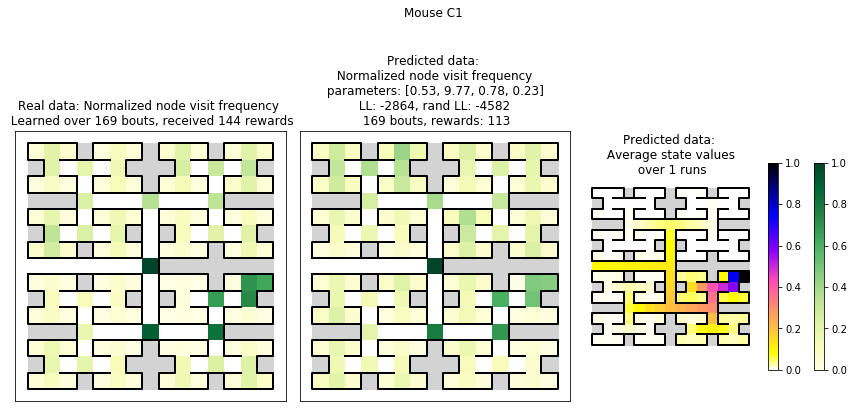

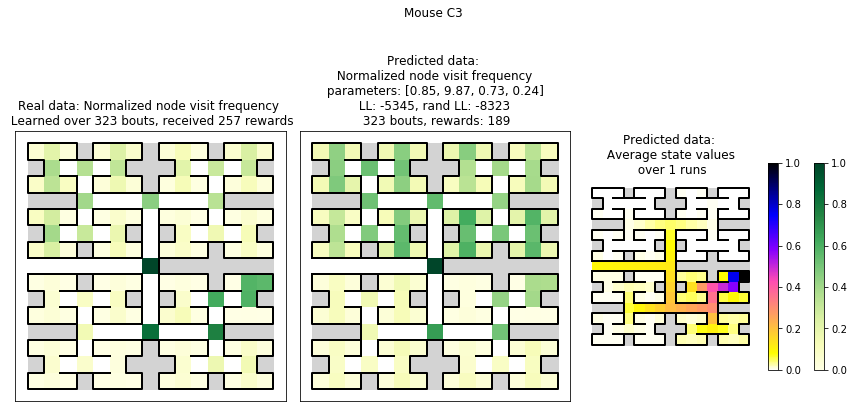

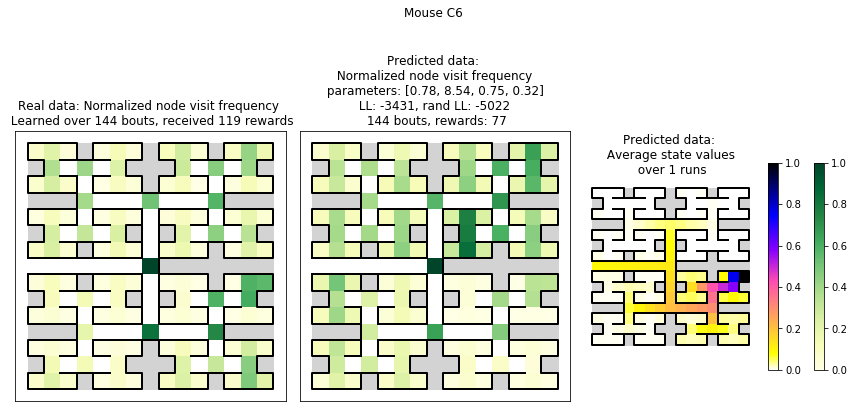

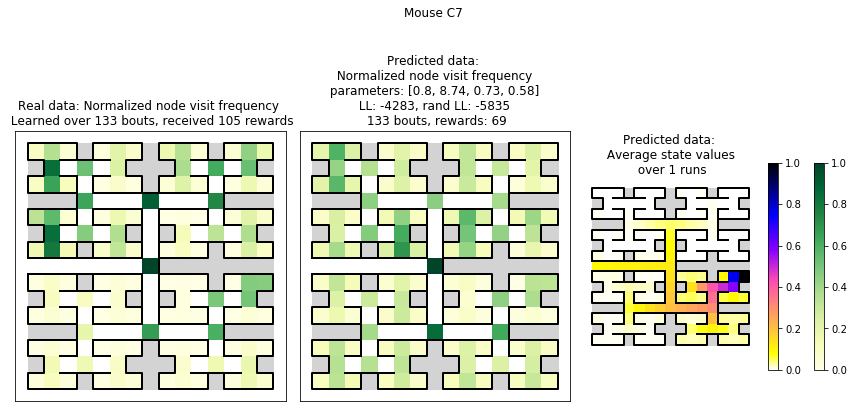

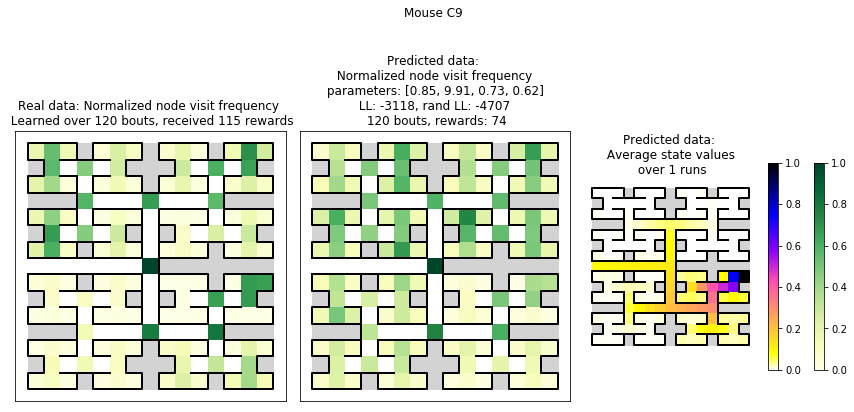

In [13]:
# Plotting frequency of real trajectories and average state values of predicted trajectories
for simID, realID in enumerate(real_mouseID):    
    # Arrange plots for a side-by-side comparison
    fig, axs = plt.subplots(1,3,figsize=(12,7.5))
    plot_maze_stats(real_traj_lists[realID], 'states', 'YlGn', axes=axs[0], display=False, cbar=True)
    plot_maze_stats(total_pred_traj_list[simID], 'states', 'YlGn', axes=axs[1], display=False, cbar=False)
    plot_maze_stats(avg_state_value_hist[simID][:-1], 'state_values', 'gnuplot2_r', axes=axs[2], display=False, cbar=True)
    axs[0].set_title('Real data: Normalized node visit frequency \n Learned over %i bouts, received %i rewards'
                  %(N_BOUTS[simID], NRWDS[simID]))
    axs[0].invert_yaxis()
    axs[1].set_title('Predicted data: \n Normalized node visit frequency \n parameters: %s \n LL: %.f, rand LL: %.f \n %i bouts, rewards: %i' 
                     %(str([np.round(val,2) for val in sub_fits[simID][:-1]]), sub_fits[simID][-1], indv_rand_LL[realID], 
                    N_BOUTS_TO_GENERATE[simID], total_rwds[simID]))
    axs[1].invert_yaxis()
    axs[2].set_title('Predicted data: \n Average state values \n over %i runs' %(RUNS))
    axs[2].invert_yaxis()
    fig.suptitle('Mouse %s' %(RewNames[realID]))
#     fig.savefig(save_dir + 'TDlambda_moreXP/' + RewNames[realID]+'.png')

Text(0.5, 0.98, 'Real vs Average Predicted Reward Rates')

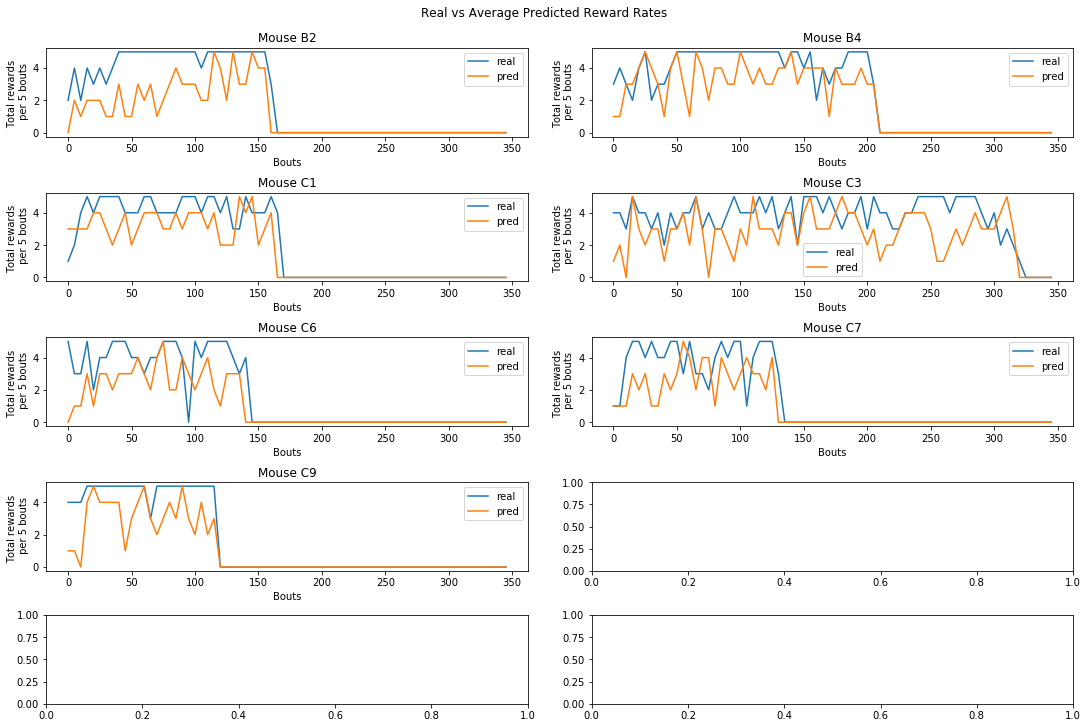

In [14]:
# Calculating reward rates as sum of rewards per B_RWD bouts
B_RWD = 5
NBINS = np.max([len(RWD_RATE[0]), np.max(N_BOUTS_TO_GENERATE)]) // B_RWD
fig, axs = plt.subplots(5,2,figsize=(15,10), constrained_layout=True)
for simID, realID in enumerate(real_mouseID):
    i = simID // 2
    j = simID % 2
    binned_rwd_rate = [np.sum(RWD_RATE[realID][i*B_RWD:(i+1)*B_RWD]) for i in np.arange(NBINS)]
    binned_pred_rwd_rate = np.zeros(NBINS)
    for run in np.arange(len(pred_rwd_rate[simID])):
        filler = np.zeros(NBINS)
        RBINS = len(pred_rwd_rate[simID][run]) // B_RWD
        temp = [np.sum(pred_rwd_rate[simID][run][i*B_RWD:(i+1)*B_RWD]) for i in np.arange(RBINS)]
        filler[0:len(temp)] = temp
        binned_pred_rwd_rate += filler
        
    axs[i,j].plot(np.arange(0,NBINS*B_RWD,B_RWD), binned_rwd_rate, label='real')
    axs[i,j].plot(np.arange(0,NBINS*B_RWD,B_RWD), binned_pred_rwd_rate/RUNS, label='pred')
    axs[i,j].set_title('Mouse %s' %(RewNames[realID]))
    axs[i,j].set_xlabel('Bouts')
    axs[i,j].set_ylabel('Total rewards \n per %i bouts' %(B_RWD))
    axs[i,j].legend()
fig.suptitle('Real vs Average Predicted Reward Rates')
# fig.savefig(save_dir + 'TDlambda_moreXP/rewardrate.png')